Define 2 distances which we want to minimize:

1. Content Distance: the squared error between concatenated layers from the pre-trained network. So choose a layer depth and extract that layer from both the images of interest.
2. Style Distance: For each image, calculate the gram product. To do this select a layer with k feature maps. You then create a kxk matric where each element is the dot product of the corresponding feature maps. Basically, a measure of correlation. You then take the squared error between these gram products to get the distance.

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy
%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Read in data

Note: PIL images are valued between 0 to 255, when transformed to tensors, converted to 0-1. Pytorch models are trained with 0-1 tensor images.

In [7]:
imsize = 512 if torch.cuda.is_available() else 128
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()
])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("./images/picasso.jpg")
content_img = image_loader("./images/dancing.jpg")

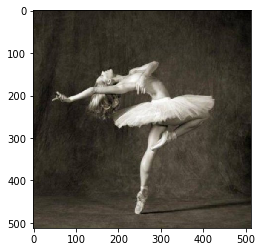

In [17]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone() #clone so don't change
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    
imshow(content_img)

### Content Loss

In [19]:
class ContentLoss(nn.Module):
    
    def __init__(self, target, ):
        super(ContentLoss, self).__init__()
        ## detach to prevent gradients from being calculated
        self.target = target.detach()
        
    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style Loss

In [22]:
def gram_matrix(input):
    a, b, c, d = input.size() # batch_size (1), # feature maps, lxw of feature maps
    features = input.view(a*b, c*d) # just create one vector per feature map
    G = torch.mm(features, features.t()) # compute gram matrix
    return G.div(a*b*c*d) #normalize feature map

class StyleLoss(nn.Module):
    
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

### Pre-trained Net

Models come with 2 parts: Features and classifier. We just need features. We use eval b/c wont be training and some parts like dropout act differently.

VGG is normalized as followed: mean=[0.485, 0.456, 0.406] and std=[0.229, 0.224, 0.225]

In [23]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
        
    def forward(self, img):
        return (img - self.mean) / self.std

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /home/tyler/.torch/models/vgg19-dcbb9e9d.pth
100%|██████████| 574673361/574673361 [02:12<00:00, 4321683.27it/s]


In [ ]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                              style_img, content_img
                              content_layers=content_layers_default,
                              style_layers=style_layers_default):